# Andy Quintero


# Part 1- Twitter Hate Speech

A tweet contains hate speech if it has a racist or sexist sentiment associated with it. Given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist. The objective is to:
- a) Create a model to ​detect hate speech in tweets
- b) Apply a second model (unsupervised) such as topic modeling/clustering


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk 
 

df = pd.read_csv('train_tweets.csv')

print(df.shape)
df.head(10)

(31962, 3)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


31,962 rows, 3 columns

Dropping "id" column as it does not have any useful information

In [3]:
df = df.drop('id', 1)

Let's see if there are any duplicates

In [4]:
dups = df[df.duplicated(keep='last')]
dups.shape

(2432, 2)

No duplicates, check for null data

In [5]:
df.apply(lambda x: sum(x.isnull()), axis=0) 

label    0
tweet    0
dtype: int64

No null data

Let's check out a few non racist/sexist tweets.

In [6]:
df[df['label'] == 0].head(10)

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
5,0,[2/2] huge fan fare and big talking before the...
6,0,@user camping tomorrow @user @user @user @use...
7,0,the next school year is the year for exams.ð...
8,0,we won!!! love the land!!! #allin #cavs #champ...
9,0,@user @user welcome here ! i'm it's so #gr...


Now check out a few racist/sexist tweets.

In [7]:
df[df['label'] == 1].head(10)

,label,tweet
13,1,@user #cnn calls #michigan middle school 'buil...
14,1,no comment! in #australia #opkillingbay #se...
17,1,retweet if you agree!
23,1,@user @user lumpy says i am a . prove it lumpy.
34,1,it's unbelievable that in the 21st century we'...
56,1,@user lets fight against #love #peace
68,1,ð©the white establishment can't have blk fol...
77,1,"@user hey, white people: you can call people '..."
82,1,how the #altright uses &amp; insecurity to lu...
111,1,@user i'm not interested in a #linguistics tha...


# EDA

In [8]:
df.describe()

,label
count,31962.000000
mean,0.070146
std,0.255397
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Let's have a glimpse at label-distribution in the twitter dataset.

In [9]:
df["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

Percentage of Non Racist/sexist - Racist/Sexist

In [10]:
print("Non Racist/sexist: ", df.label.value_counts()[0]/len(df)*100,"%")
print("Racist/sexist: ", df.label.value_counts()[1]/len(df)*100,"%")

Non Racist/sexist:  92.98542018647143 %
Racist/sexist:  7.014579813528565 %


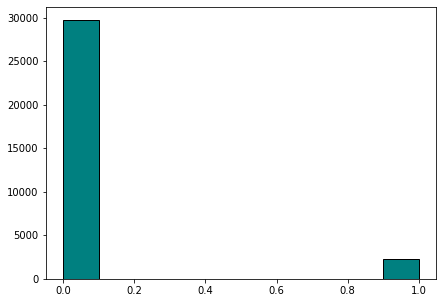

In [11]:
plt.figure(figsize=(7, 5))
plt.hist(df['label'], color = 'teal', edgecolor = 'black', bins=10);

We have 2,242 (7%) tweets labeled as racist or sexist(1), and 29,720 (93%) tweets labeled as non racist/sexist(0). So, our dataset it's imbalanced.

# Visualizing tweet text length

In [12]:
print('review tweet length')
df['tweet'].str.len().describe()

review tweet length


count    31962.000000
mean        84.739628
std         29.455749
min         11.000000
25%         63.000000
50%         88.000000
75%        108.000000
max        274.000000
Name: tweet, dtype: float64

average review has 84 characters, but there are some long tweets. Let's inspect some of these.

In [13]:
longtweets = df[df['tweet'].str.len()>200]

print(longtweets.index)
longtweets.shape

Int64Index([13459, 18433, 19770, 31485], dtype='int64')


(4, 2)

In [14]:
print(df.iloc[13459]['tweet'])

awesom beautiful wonderfulððððððððððððð±ð±ð±ð±ð±ð±ðððððððððððððððððððððððððððððððððð»ð»ð»ð» 


In [15]:
print(df.iloc[18433]['tweet'])

 @user rotterdam â¢ socafrenzy â¢  ðð¿ðð¿ðð¿ â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢ #dj #djlife  â¦ 


We can see that our two longest tweets contain symbols. We will clean this.

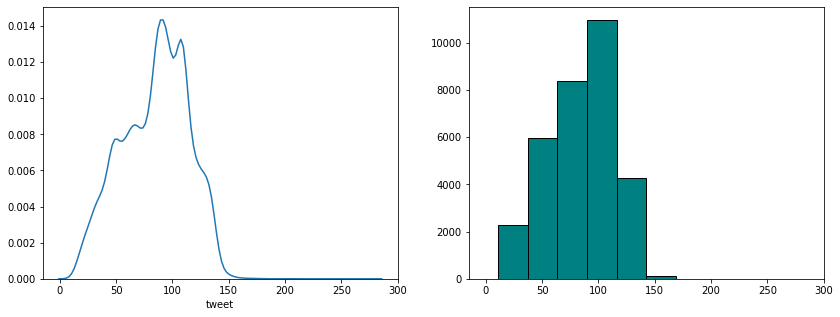

In [16]:
f, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

plt.hist(df['tweet'].str.len(), color = 'teal', edgecolor = 'black')
sns.distplot(df['tweet'].str.len(), hist=False, ax=axes[0]);

# Visualizing tweet word length

In [17]:
print('tweet word length')
df['tweet'].str.split().map(lambda x: len(x)).describe()

tweet word length


count    31962.00000
mean        13.15872
std          5.47815
min          3.00000
25%          9.00000
50%         13.00000
75%         17.00000
max         34.00000
Name: tweet, dtype: float64

average word length is 13.

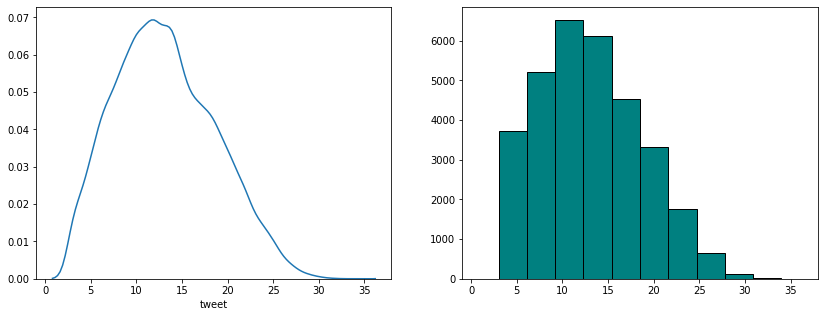

In [18]:
f, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

plt.hist(df['tweet'].str.split().map(lambda x: len(x)), color = 'teal', edgecolor = 'black');
sns.distplot(df['tweet'].str.split().map(lambda x: len(x)), hist=False, ax=axes[0] );

# Top Words

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)


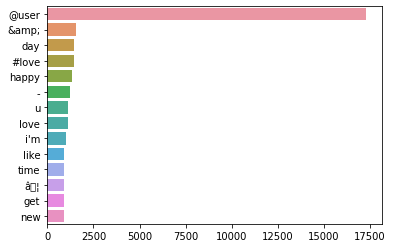

In [19]:
from nltk.corpus import stopwords
import collections
import seaborn as sns

# create the corpus for the text
corpus=[]
tweet = df['tweet'].str.split().values.tolist()
corpus=[word for i in tweet for word in i]


stop=set(stopwords.words('english'))
counter = collections.Counter(corpus)
most = counter.most_common()

x, y= [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x);

# Data Cleaning

In [20]:
from nltk import stem
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string 
import re

stemmer = stem.PorterStemmer()

useless_words = stopwords.words("english") + list(string.punctuation)

def process_tweet(tweet):
    tweet = tweet.lower() # normalize case
    
    #remvove @'s'
    tweet = re.sub('\S*@\S*\s?', '', tweet)  
    
    # tokenize, remove stopwords and punctuation
    tweet = [word for word in word_tokenize(tweet) if word not in useless_words] 
    
    #stem
    tweet = " ".join([stemmer.stem(word) for word in tweet]) 
    
    return tweet


df_clean = df['tweet'].apply( process_tweet)

In [21]:
# test clean message
data = df['tweet'][0]
print ('orignal before cleaning\n')
print (data)

clean_data = df_clean[0]
print ('after cleaning\n')
print (clean_data)

orignal before cleaning

 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
after cleaning

father dysfunct selfish drag kid dysfunct run


Our data cleaning was a success.

# Wordcloud for Non Racist/Sexism words

Non Racist/Sexism words


(-0.5, 799.5, 499.5, -0.5)

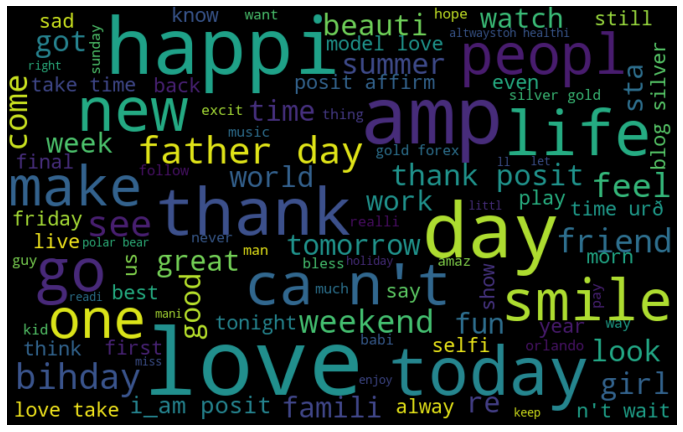

In [22]:
from wordcloud import WordCloud

non_racist = ' '.join([word for word in df_clean[df['label'] == 0]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(non_racist)
print('Non Racist/Sexism words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

# Wordcloud for Racist/Sexism words

Racist/Sexism words


(-0.5, 799.5, 499.5, -0.5)

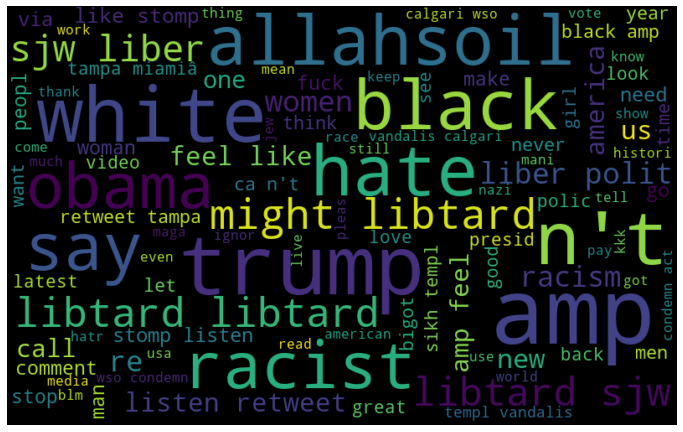

In [23]:
racist = ' '.join([word for word in df_clean[df['label'] == 1]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(racist)
print('Racist/Sexism words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

# Modeling

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as cm
import matplotlib.pyplot as plt

def getPerformance(y_true, y_pred):
    
    print(classification_report(y_true, y_pred))

    score = round(accuracy_score(y_true, y_pred),3) 
    cm1 = cm(y_true, y_pred)
    sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = 'BuGn')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Accuracy Score: {0}'.format(score), size = 12)
    plt.show()

RandomForestClassifier
Params: {'tfidfvectorizer': TfidfVectorizer(min_df=5, ngram_range=(1, 2)), 'randomforestclassifier': RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=10, random_state=1)}

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5960
           1       0.74      0.52      0.61       433

    accuracy                           0.95      6393
   macro avg       0.85      0.75      0.79      6393
weighted avg       0.95      0.95      0.95      6393



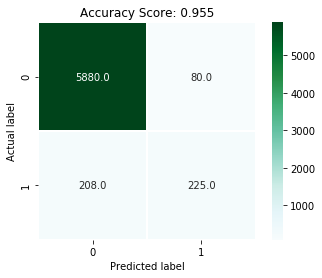


MultinomialNB
Params: {'tfidfvectorizer': TfidfVectorizer(min_df=5, ngram_range=(1, 2)), 'multinomialnb': MultinomialNB()}

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      5960
           1       0.96      0.31      0.47       433

    accuracy                           0.95      6393
   macro avg       0.95      0.66      0.72      6393
weighted avg       0.95      0.95      0.94      6393



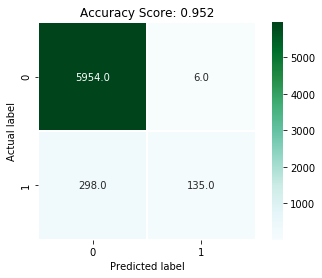


LogisticRegression
Params: {'tfidfvectorizer': TfidfVectorizer(min_df=5, ngram_range=(1, 2)), 'logisticregression': LogisticRegression(class_weight='balanced', random_state=1)}

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      5960
           1       0.48      0.80      0.60       433

    accuracy                           0.93      6393
   macro avg       0.73      0.87      0.78      6393
weighted avg       0.95      0.93      0.94      6393



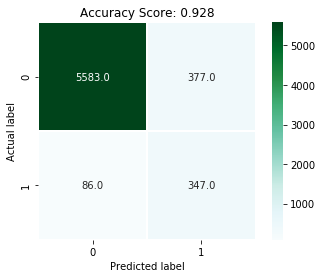

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


# split data into train and test
# default value of shuffle is True so data will be randomly splitted 
X_train, X_test, y_train, y_test = train_test_split(df_clean, df['label'], 
                                                    test_size=0.2, random_state=1)



# vectorizaton: transformer params
tfidf_params = dict(min_df = 5,         
                    ngram_range= (1,2)) #unigrams and bigrams


# list of models we would like to complete 
models = [
    RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=1, class_weight="balanced"),
    MultinomialNB(),
    LogisticRegression(random_state=1, class_weight="balanced")
 ]

# train, test and store each model 
for model in models:
    
    # create pipeline
    cls_pipe = make_pipeline(TfidfVectorizer(**tfidf_params), model)
    cls_pipe.fit(X_train, y_train)
    
    model_name = type(model).__name__
    model_params = cls_pipe.named_steps

    print(f'{model_name}')
    print(f'Params: {model_params}\n')

    # predict
    y_pred = cls_pipe.predict(X_test)
    
    # evalte
    getPerformance(y_test, y_pred)
    print()

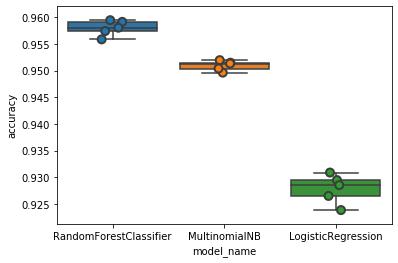

In [29]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


CV = 5  # 5 splits
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

tweets = df_clean
labels = df['label']

for model in models:
  #kfold = KFold(n_splits=CV, shuffle=True, random_state=1) 
    kfold = StratifiedKFold(n_splits=CV, shuffle=True, random_state=1) 

    model_name = model.__class__.__name__
  
    cls_pipe = make_pipeline(TfidfVectorizer(**tfidf_params), model)
    
    accuracies = cross_val_score(cls_pipe, tweets, labels, scoring='accuracy', cv=kfold)
  
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

# plot
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [30]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.927820
MultinomialNB             0.950973
RandomForestClassifier    0.958013
Name: accuracy, dtype: float64

Random Forest Classfier performed the best with 96%.

# Kmeans

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# get all tweets
tweets = df['tweet'].to_list()
print('number of tweets :', len(tweets))

clean_tweets = df_clean # list of clean tweets

#vectorization 
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_tweets)

X.shape

number of tweets : 31962


(31962, 35739)

# Elbow Method to determine how many clusters we should use in our unsupervised model.

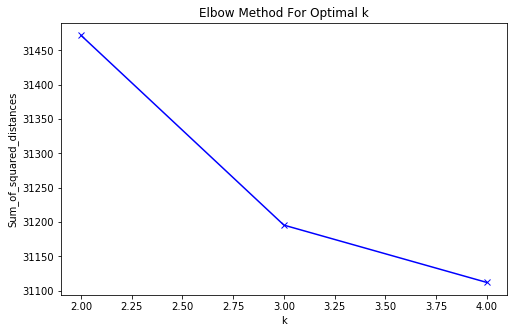

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def elbow_method(X, num_k):
    Sum_of_squared_distances = []
    for k in range(2, num_k):
        km = KMeans(n_clusters=k)
        km = km.fit(X)
        Sum_of_squared_distances.append(km.inertia_)

    # plot  
    plt.figure(figsize=(8, 5))

    plt.plot(range(2, num_k), Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

elbow_method(X, 5)

elbow method suggests k = 3

In [33]:
true_k = 3
kmeans = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, random_state=1)
kmeans.fit(X)


print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :15]:  
        print(' %s' % terms[ind]),

Top terms per cluster:
Cluster 0:
 love
 thank
 posit
 happi
 time
 take
 get
 go
 day
 life
 bihday
 affirm
 today
 make
 new
Cluster 1:
 amp
 like
 peopl
 feel
 love
 look
 followm
 make
 beauti
 get
 good
 happi
 photooftheday
 day
 cute
Cluster 2:
 day
 father
 dad
 fathersday
 happi
 love
 today
 daddi
 wish
 2016
 great
 thank
 flag
 famili
 best


0: relates to happiness 1: people feeling beautiful 2: relates to father's day.

# Predict New Tweets

In [56]:
new_docs = ["Every day I love life more and more", 
            "Today I feel beautiful",
            "Called my dad to wish him a Happy Father’s Day."]

pred = kmeans.predict(vectorizer.transform(new_docs))
print(pred)

[0 1 2]


Prediction of new tweets seems correct. First tweet assigned to happiness, 2nd to feeling beautiful, 3rd to Father's Day.

# Part2- Income Prediction

Given various features, build a predictive model to determine the income level for people in the US. The income levels are binned at below 50K (-50K) and above 50K (+50K).
- Determine features that most impact the target (eg: income) using techniques such as EDA, correlation analysis, algorithms (eg: RandomForest), Chi-Square, SelectKBest, etc.
- Apply techniques to handle imbalanced datasets: such as over sampling, undersampling and SMOTE.

In [153]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [154]:
print(train.shape)
train.head()

(199523, 41)


,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_lastwk,marital_status,major_industry_code,major_occupation_code,...,country_father,country_mother,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,weeks_worked_in_year,year,income_level
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,-50000
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,-50000
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,-50000
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,-50000
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,-50000


In [155]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 41 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   age                               199523 non-null  int64 
 1   class_of_worker                   199523 non-null  object
 2   industry_code                     199523 non-null  int64 
 3   occupation_code                   199523 non-null  int64 
 4   education                         199523 non-null  object
 5   wage_per_hour                     199523 non-null  int64 
 6   enrolled_in_edu_inst_lastwk       199523 non-null  object
 7   marital_status                    199523 non-null  object
 8   major_industry_code               199523 non-null  object
 9   major_occupation_code             199523 non-null  object
 10  race                              199523 non-null  object
 11  hispanic_origin                   198649 non-null  object
 12  se

The information above reveals that there are no missing values in the datatset.

number of categorical and numerical features

In [156]:
print("Number of categorical features : {}".format(len(train.select_dtypes(include=['object']).columns)))
print("Number of numerical features : {}".format(len(train.select_dtypes(include=['int64', 'float64']).columns)))

Number of categorical features : 28
Number of numerical features : 13


In [157]:
# statistics of numeric data
train.describe()

,age,industry_code,occupation_code,wage_per_hour,capital_gains,capital_losses,dividend_from_Stocks,num_person_Worked_employer,business_or_self_employed,veterans_benefits,weeks_worked_in_year,year,income_level
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1.956180,0.175438,1.514833,23.174897,94.499672,-43794.199165
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,2.365126,0.553694,0.851473,24.411488,0.500001,24126.148404
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.000000,-50000.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,94.000000,-50000.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,2.000000,8.000000,94.000000,-50000.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,4.000000,0.000000,2.000000,52.000000,95.000000,-50000.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000,50000.000000


199523 rows and we also see some 0's and 1.

# Data Exploration and Visualization

In [159]:
#Separate categorical and numberical columns
cat_col = train.dtypes[train.dtypes == 'object']
num_col = train.dtypes[train.dtypes != 'object']

In [160]:
for col in list(cat_col.index):
    print(f"--------------------{col.title()}-------------------------")
    total= train[col].value_counts()
    percent = train[col].value_counts() / train.shape[0]
    df2 = pd.concat([total,percent],keys = ['total','percent'],axis = 1)
    print(df2)
    print('\n')

--------------------Class_Of_Worker-------------------------
                                 total   percent
Not in universe                 100245  0.502423
Private                          72028  0.361001
Self-employed-not incorporated    8445  0.042326
Local government                  7784  0.039013
State government                  4227  0.021186
Self-employed-incorporated        3265  0.016364
Federal government                2925  0.014660
Never worked                       439  0.002200
Without pay                        165  0.000827


--------------------Education-------------------------
                                        total   percent
High school graduate                    48407  0.242614
Children                                47422  0.237677
Some college but no degree              27820  0.139433
Bachelors degree(BA AB BS)              19865  0.099562
7th and 8th grade                        8007  0.040131
10th grade                               7557  0.037875


# Class of worker

- We can see that 50% of the data is not in universe.
- Self-emp-not-inc, Self-emp-inc comes under category self employed
- Local-gov,State-gov,Federal-gov comes under category goverment emloyees
 
# Education

- 9th, 10th, 11th, 12th comes under HighSchool Grad but it has mentioned separately
- Create Elementary object for 1st-4th, 5th-6th, 7th-8th
- Preschool also childrens

# Enrolled in Education in last week

- 93% of the data is also not in universe

# Marital Status

- Married-civilian spouse present, Married-spouse absent,Married-AF spouse comes under category Married
- Divorced, separated again comes under category separated.

# Race

- 83% are white.

# Sex

- 52% are female

# Full Part-time Employment Stat

- 62% Children or Armed Forces

In [161]:
for col in list(num_col.index):
    print(f"--------------------{col.title()}-------------------------")
    total= train[col].value_counts()
    percent = train[col].value_counts() / train.shape[0]
    df2 = pd.concat([total,percent],keys = ['total','percent'],axis = 1)
    print(df2)
    print('\n')

--------------------Age-------------------------
    total   percent
34   3489  0.017487
35   3450  0.017291
36   3353  0.016805
31   3351  0.016795
33   3340  0.016740
..    ...       ...
85    423  0.002120
86    348  0.001744
87    301  0.001509
88    241  0.001208
89    195  0.000977

[91 rows x 2 columns]


--------------------Industry_Code-------------------------
     total   percent
0   100684  0.504624
33   17070  0.085554
43    8283  0.041514
4     5984  0.029992
42    4683  0.023471
45    4482  0.022464
29    4209  0.021095
37    4022  0.020158
41    3964  0.019867
32    3596  0.018023
35    3380  0.016940
39    2937  0.014720
34    2765  0.013858
44    2549  0.012775
2     2196  0.011006
11    1764  0.008841
50    1704  0.008540
40    1651  0.008275
47    1644  0.008240
38    1629  0.008164
24    1503  0.007533
12    1350  0.006766
19    1346  0.006746
30    1181  0.005919
31    1178  0.005904
25    1084  0.005433
9      993  0.004977
22     952  0.004771
36     945  0.0047

# Income Level

- 93% made less than 50k.

# Grouping below to organized our data a little more.

In [162]:
highschool = ['10th grade','11th grade','9th grade','12th grade no diploma']
elementary = ['1st 2nd 3rd or 4th grade','5th or 6th grade','7th and 8th grade']
preschool = ['Less than 1st grade', 'Children']
# replace elements in list.
train['education'].replace(to_replace = highschool,value = 'highschool',inplace = True)
train['education'].replace(to_replace = elementary,value = 'elementary_school',inplace = True)
train['education'].replace(to_replace = preschool,value = 'preschool',inplace = True)

train['education'].value_counts()

High school graduate                      48407
preschool                                 48241
Some college but no degree                27820
highschool                                22789
Bachelors degree(BA AB BS)                19865
elementary_school                         13083
Masters degree(MA MS MEng MEd MSW MBA)     6541
Associates degree-occup /vocational        5358
Associates degree-academic program         4363
Prof school degree (MD DDS DVM LLB JD)     1793
Doctorate degree(PhD EdD)                  1263
Name: education, dtype: int64

In [163]:
married= ['Married-spouse absent','Married-civilian spouse present','Married-A F spouse present']
separated = ['Separated','Divorced']

#replace elements in list.
train['marital_status'].replace(to_replace = married ,value = 'Married',inplace = True)
train['marital_status'].replace(to_replace = separated,value = 'Separated',inplace = True)

train['marital_status'].value_counts()

Never married    86485
Married          86405
Separated        16170
Widowed          10463
Name: marital_status, dtype: int64

In [164]:
self_employed = ['Self-employed-not incorporated','Self-employed-incorporated']
govt_employees = ['Local government','State government','Federal government']

#replace elements in list.
train['class_of_worker'].replace(to_replace = govt_employees,value = 'Govt_employees',inplace = True)

train['class_of_worker'].value_counts()

Not in universe                   100245
Private                            72028
Govt_employees                     14936
Self-employed-not incorporated      8445
Self-employed-incorporated          3265
Never worked                         439
Without pay                          165
Name: class_of_worker, dtype: int64

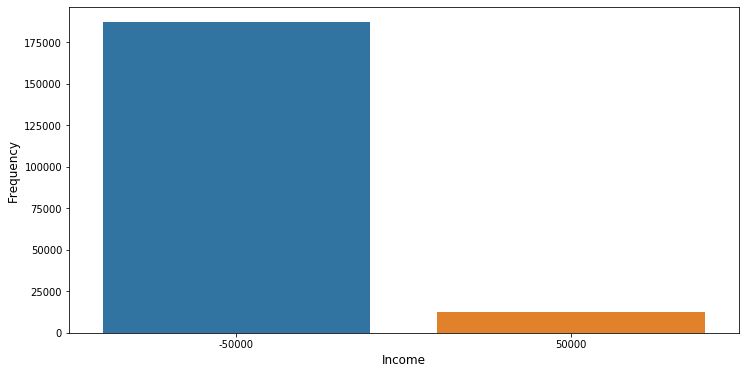

In [165]:
plt.figure(figsize =(12,6));
sns.countplot(x = 'income_level', data = train);
plt.xlabel("Income",fontsize = 12);
plt.ylabel("Frequency",fontsize = 12);

- 93% made less than 50k.

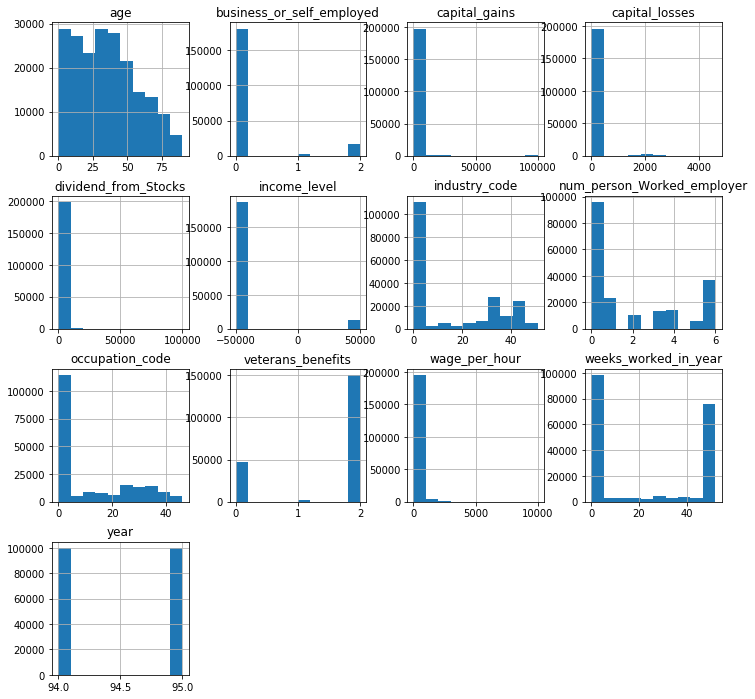

In [166]:
train[list(num_col.index)].hist(figsize = (12,12));

- age: in our dataset are people from age group of 0-50 can be observed.

Let's explore more for people having capital loss and capital gain greater than zero.

In [167]:
# Exploring Case when capital.gain and capital loss both are zero. As this category of people are more in our dataset.
print(f"Number of observations having capital gain and capital loss zero: {train[(train['capital_losses'] == 0) & (train['capital_gains'] == 0)].shape}")
for col in cat_col.index:
    print(f"================================{col}=================================")
    print(train[(train['capital_losses'] == 0) & (train['capital_gains'] == 0)][col].value_counts())

Number of observations having capital gain and capital loss zero: (188238, 41)
================================class_of_worker=================================
Not in universe                   97941
Private                           65960
Govt_employees                    13518
Self-employed-not incorporated     7565
Self-employed-incorporated         2654
Never worked                        439
Without pay                         161
Name: class_of_worker, dtype: int64
================================education=================================
preschool                                 48231
High school graduate                      45414
Some college but no degree                25798
highschool                                21994
Bachelors degree(BA AB BS)                17433
elementary_school                         12626
Masters degree(MA MS MEng MEd MSW MBA)     5510
Associates degree-occup /vocational        4924
Associates degree-academic program         4010
Prof school degre

In [168]:
train.loc[train['capital_gains'] > 0,:].describe()

,age,industry_code,occupation_code,wage_per_hour,capital_gains,capital_losses,dividend_from_Stocks,num_person_Worked_employer,business_or_self_employed,veterans_benefits,weeks_worked_in_year,year,income_level
count,7379.000000,7379.000000,7379.000000,7379.000000,7379.000000,7379.0,7379.000000,7379.000000,7379.000000,7379.000000,7379.000000,7379.000000,7379.000000
mean,48.498713,23.721778,14.463342,77.855536,11754.497493,0.0,1028.065727,3.205177,0.257623,1.983060,39.456024,94.517143,-17312.643990
std,16.714839,17.465886,14.185785,342.611552,21533.053259,0.0,5705.566577,2.349491,0.646241,0.129055,20.671292,0.499740,46910.239594
min,15.000000,0.000000,0.000000,0.000000,114.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,94.000000,-50000.000000
25%,36.000000,3.000000,2.000000,0.000000,2964.000000,0.0,0.000000,1.000000,0.000000,2.000000,32.000000,94.000000,-50000.000000
50%,46.000000,31.000000,10.000000,0.000000,5178.000000,0.0,0.000000,3.000000,0.000000,2.000000,52.000000,95.000000,-50000.000000
75%,62.000000,39.000000,28.000000,0.000000,10520.000000,0.0,40.000000,6.000000,0.000000,2.000000,52.000000,95.000000,50000.000000
max,90.000000,51.000000,46.000000,5500.000000,99999.000000,0.0,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000,50000.000000


Maximum value of capital gain is 99999 which is far above 75% quartile range.This is definitely an outlier. Lets try and understand more about this maximum value of 99999.

In [169]:
print(f"Number of observations having capital gain of 99999:{train.loc[train['capital_gains'] == 99999,:].shape}")
print(f"Income counts: {train.loc[train['capital_gains'] == 99999,:]['income_level'].value_counts()}")

Number of observations having capital gain of 99999:(390, 41)
Income counts:  50000    344
-50000     46
Name: income_level, dtype: int64


Ok,So their income is greater than 50K which is exactly what I expected.

In [170]:
train.loc[train['capital_losses'] > 0,:].describe()

,age,industry_code,occupation_code,wage_per_hour,capital_gains,capital_losses,dividend_from_Stocks,num_person_Worked_employer,business_or_self_employed,veterans_benefits,weeks_worked_in_year,year,income_level
count,3906.000000,3906.000000,3906.000000,3906.000000,3906.0,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000
mean,44.189964,25.075525,16.211470,80.243472,0.0,1906.031490,714.360215,3.453917,0.275218,1.981567,41.386073,94.497440,-20071.684588
std,15.853515,16.910329,14.348768,370.717723,0.0,463.154428,4498.025817,2.266846,0.667355,0.134529,18.801843,0.500057,45800.267623
min,15.000000,0.000000,0.000000,0.000000,0.0,155.000000,0.000000,0.000000,0.000000,1.000000,0.000000,94.000000,-50000.000000
25%,32.000000,4.000000,2.000000,0.000000,0.0,1669.000000,0.000000,1.000000,0.000000,2.000000,40.000000,94.000000,-50000.000000
50%,42.000000,32.000000,13.000000,0.000000,0.0,1887.000000,0.000000,4.000000,0.000000,2.000000,52.000000,94.000000,-50000.000000
75%,54.000000,40.000000,30.000000,0.000000,0.0,2001.000000,0.000000,6.000000,0.000000,2.000000,52.000000,95.000000,50000.000000
max,90.000000,51.000000,46.000000,7400.000000,0.0,4608.000000,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000,50000.000000


In [171]:
print(f"Number of observations having capital loss of 4356:{train.loc[train['capital_losses'] == 4356,:].shape}")
print("\nIncome Distribution among people with capital loss above mean:")
print(f"Income counts:\n{train.loc[train['capital_losses'] >= 1906,:]['income_level'].value_counts()}")

Number of observations having capital loss of 4356:(30, 41)

Income Distribution among people with capital loss above mean:
Income counts:
-50000    856
 50000    677
Name: income_level, dtype: int64


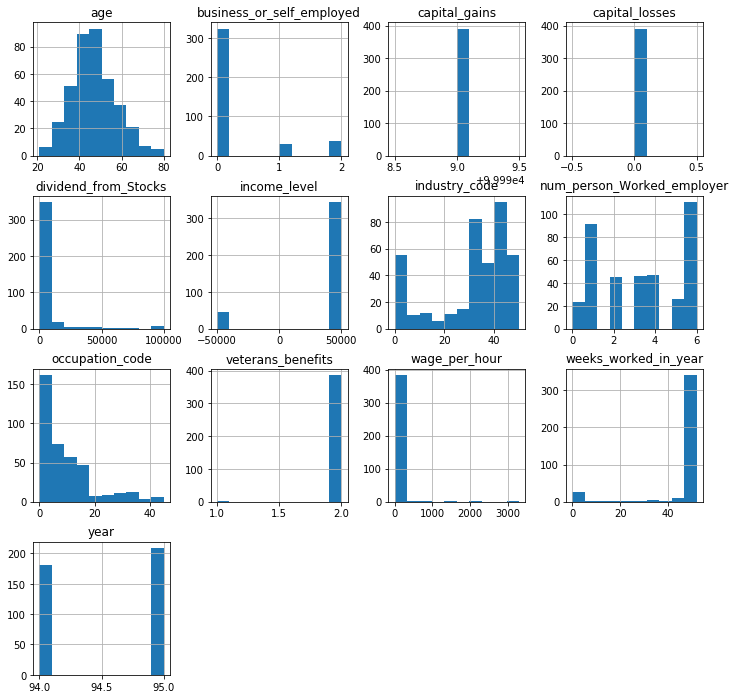

In [172]:
train.loc[train['capital_gains'] == 99999,:].hist(figsize = (12,12));

In [173]:
# missing value counts

train.apply(lambda x: sum(x.isnull()), axis=0) 

age                                     0
class_of_worker                         0
industry_code                           0
occupation_code                         0
education                               0
wage_per_hour                           0
enrolled_in_edu_inst_lastwk             0
marital_status                          0
major_industry_code                     0
major_occupation_code                   0
race                                    0
hispanic_origin                       874
sex                                     0
member_of_labor_union                   0
reason_for_unemployment                 0
full_parttime_employment_stat           0
capital_gains                           0
capital_losses                          0
dividend_from_Stocks                    0
tax_filer_status                        0
region_of_previous_residence            0
state_of_previous_residence           708
d_household_family_stat                 0
d_household_summary               

Dropping the following columns as per our finding at the beginning there is a lot of missing data.

In [174]:
train.drop(columns=['enrolled_in_edu_inst_lastwk', 'hispanic_origin','member_of_labor_union','region_of_previous_residence',
                    'state_of_previous_residence','migration_msa','migration_reg','migration_within_reg','live_1_year_ago','d_household_summary',
                    'migration_sunbelt','major_industry_code','major_occupation_code','country_mother','citizenship','d_household_family_stat','family_members_under_18','country_self',
                    'fill_questionnaire_veteran_admin','reason_for_unemployment','full_parttime_employment_stat','tax_filer_status','veterans_benefits','country_father','year'], inplace=True)

# encode categorical

In [175]:
from sklearn.preprocessing import LabelEncoder

var_mod = ['class_of_worker','education','marital_status','race','sex']

le = LabelEncoder()
for i in var_mod:
    train[i] = le.fit_transform(train[i].astype(str))

train.dtypes

age                           int64
class_of_worker               int64
industry_code                 int64
occupation_code               int64
education                     int64
wage_per_hour                 int64
marital_status                int64
race                          int64
sex                           int64
capital_gains                 int64
capital_losses                int64
dividend_from_Stocks          int64
num_person_Worked_employer    int64
business_or_self_employed     int64
weeks_worked_in_year          int64
year                          int64
income_level                  int64
dtype: object

# Correlation Matrix

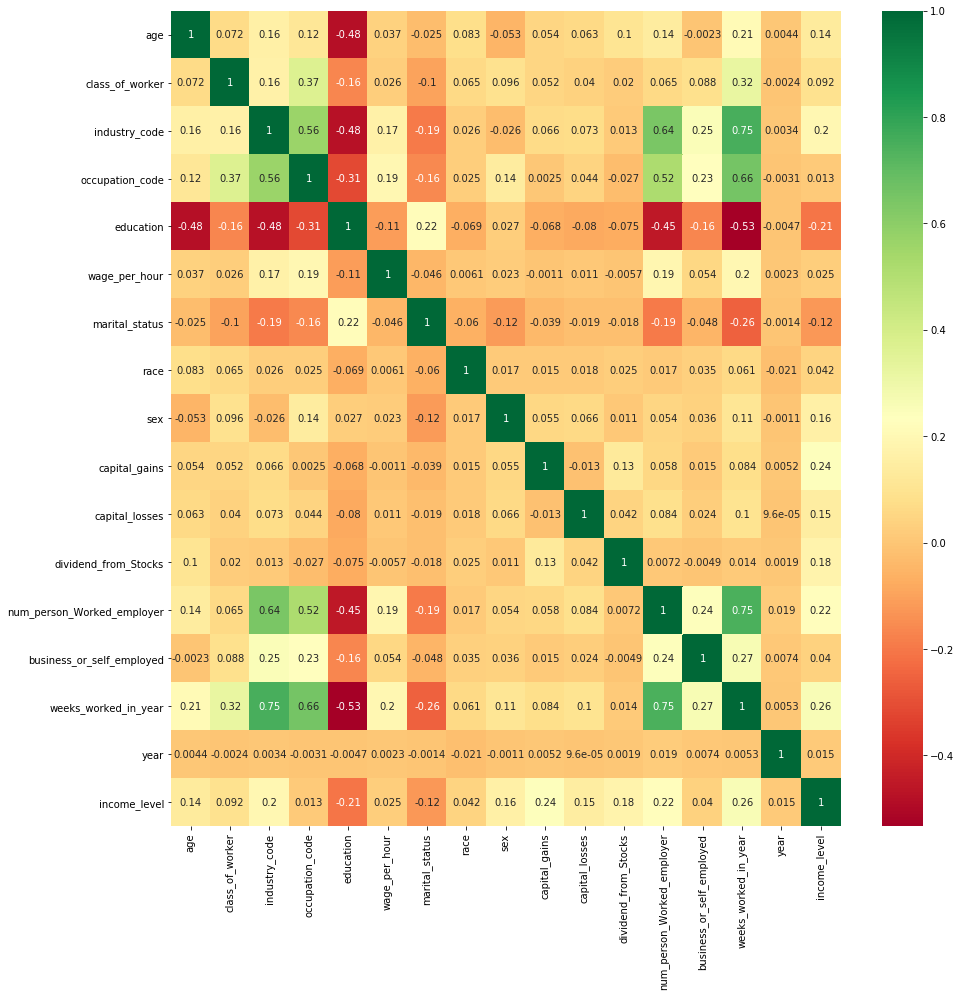

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))

#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

- industry code and weeks worked in year have a correlation
- number of person worked employer and weeks worked in year as well

# categorical features

In [201]:
catFeatures = train[['age','class_of_worker','industry_code','occupation_code','education','wage_per_hour','marital_status',
                 'race', 'sex','capital_losses','dividend_from_Stocks','num_person_Worked_employer','business_or_self_employed',
                 'weeks_worked_in_year','year','income_level']]
catFeatures.head()

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,marital_status,race,sex,capital_losses,dividend_from_Stocks,num_person_Worked_employer,business_or_self_employed,weeks_worked_in_year,year,income_level
0,73,2,0,0,4,0,3,4,0,0,0,0,0,0,95,-50000
1,58,5,4,34,7,0,2,4,1,0,0,1,0,52,94,-50000
2,18,2,0,0,9,0,1,1,0,0,0,0,0,0,95,-50000
3,9,2,0,0,10,0,1,4,0,0,0,0,0,0,94,-50000
4,10,2,0,0,10,0,1,4,0,0,0,0,0,0,94,-50000


In [178]:
import researchpy as rp

for c in catFeatures.columns:
    if c=='income_level':
        continue
    print(rp.summary_cat(train[[c, "income_level"]]), '\n')
    

        Variable  Outcome   Count  Percent
0            age       34    3489     1.75
1                      35    3450     1.73
2                      36    3353     1.68
3                      31    3351     1.68
4                      33    3340     1.67
..           ...      ...     ...      ...
88                     87     301     0.15
89                     88     241     0.12
90                     89     195     0.10
91  income_level   -50000  187141    93.79
92                  50000   12382     6.21

[93 rows x 4 columns] 

          Variable  Outcome   Count  Percent
0  class_of_worker        2  100245    50.24
1                         3   72028    36.10
2                         0   14936     7.49
3                         5    8445     4.23
4                         4    3265     1.64
5                         1     439     0.22
6                         6     165     0.08
7     income_level   -50000  187141    93.79
8                     50000   12382     6.21 

       

The amount of people that made less than 50k for 94 and 95 is pretty the same. 

# Feature Selection using RandomForest

In [179]:
train.columns

Index(['age', 'class_of_worker', 'industry_code', 'occupation_code',
       'education', 'wage_per_hour', 'marital_status', 'race', 'sex',
       'capital_gains', 'capital_losses', 'dividend_from_Stocks',
       'num_person_Worked_employer', 'business_or_self_employed',
       'weeks_worked_in_year', 'year', 'income_level'],
      dtype='object')

In [180]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

# All columns
predictors = ['age','class_of_worker','industry_code','occupation_code','education','wage_per_hour','marital_status',
                 'race', 'sex','capital_losses','dividend_from_Stocks','num_person_Worked_employer','business_or_self_employed',
                 'weeks_worked_in_year']


# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(train[predictors], 
                                                    train['income_level'], 
                                                    test_size=0.3, random_state=0)

#Smote to handle with the inbalanced of the dataset.

sm = SMOTE(sampling_strategy=0.1)
X_train, y_train = sm.fit_sample(X_train, y_train)


# Create a random forest classifier fpr feature importance
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(predictors, clf.feature_importances_):
    print(feature)

('age', 0.1711451872222067)
('class_of_worker', 0.03214631129573715)
('industry_code', 0.11205341016298188)
('occupation_code', 0.1603855814750062)
('education', 0.0977287248026629)
('wage_per_hour', 0.01704554423938383)
('marital_status', 0.030459664219681732)
('race', 0.017767149255514206)
('sex', 0.03878016774664573)
('capital_losses', 0.02822490803571368)
('dividend_from_Stocks', 0.12095982938608524)
('num_person_Worked_employer', 0.06364747419020897)
('business_or_self_employed', 0.019369892404237945)
('weeks_worked_in_year', 0.06672421672099448)
('year', 0.023561938842939438)


# Identify And Select Most Important Features

In [181]:
# Create a selector object that uses the random forest classifier to identify
# features that have an importance of more than 0.10
sfm = SelectFromModel(clf, threshold=0.10)

# Train the selector
sfm.fit(X_train, y_train)

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(predictors[feature_list_index])

age
industry_code
occupation_code
dividend_from_Stocks


# Create A Data Subset With Only the most important Features and compare the accuracy Of the Full Feature Classifier to the Limited Feature Classifier

In [182]:
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)


clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

clf_important.fit(X_important_train, y_train)

# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)
print('full model:', accuracy_score(y_test, y_pred))


# Apply The limited Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

print('limited model:', accuracy_score(y_test, y_important_pred))

full model: 0.9499139616085003
limited model: 0.9376681089931003


The original model which contained all features is only slightly more accurate than the ‘limited’ model with only the following features:
age, industry_code, occupation_code_dividend_from_stocks

# Chi-Square Feature Selection for categorical

In [183]:
from sklearn.feature_selection import chi2

y = catFeatures ['income_level'].values

catFeatures = catFeatures.drop(['income_level'], axis=1)
x = catFeatures.values

chi_scores = chi2(x, y)
chi_scores

(array([5.30357651e+04, 7.01701258e+02, 1.63285428e+05, 6.63385633e+02,
        1.21858776e+04, 1.63659072e+05, 2.59897881e+03, 7.22686041e+01,
        2.58305152e+03, 8.59061060e+06, 1.22871166e+08, 2.82923086e+04,
        5.71119727e+02, 3.53029907e+05, 1.15521017e-01]),
 array([0.00000000e+000, 1.27571895e-154, 0.00000000e+000, 2.74185723e-146,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.87811735e-017,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        3.20439695e-126, 0.00000000e+000, 7.33944015e-001]))

In [186]:
# supporess scientific notation
pd.set_option('display.float_format', lambda x: '%.10f' % x)

p_values = pd.Series(chi_scores[1], index = catFeatures.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values

year                         0.7339440152
race                         0.0000000000
business_or_self_employed    0.0000000000
occupation_code              0.0000000000
class_of_worker              0.0000000000
weeks_worked_in_year         0.0000000000
num_person_Worked_employer   0.0000000000
dividend_from_Stocks         0.0000000000
capital_losses               0.0000000000
sex                          0.0000000000
marital_status               0.0000000000
wage_per_hour                0.0000000000
education                    0.0000000000
industry_code                0.0000000000
age                          0.0000000000
dtype: float64

# SelectKBest for Feature Selection

In [187]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

selector = SelectKBest(score_func=chi2, # Chi-squared stats of non-negative features for classification tasks
                       k='all')  

#y = catFeatures ['Loan_Status'].values
#catFeatures = catFeatures.drop(['Loan_Status'], axis=1)
#x = catFeatures.values
    
# apply feature selection
x_selected = selector.fit_transform(x, y)

print(x_selected.shape)
print('feature scores: ', selector.scores_,)
print('feature p-values scores:',  selector.pvalues_)

(199523, 15)
feature scores:  [5.30357651e+04 7.01701258e+02 1.63285428e+05 6.63385633e+02
 1.21858776e+04 1.63659072e+05 2.59897881e+03 7.22686041e+01
 2.58305152e+03 8.59061060e+06 1.22871166e+08 2.82923086e+04
 5.71119727e+02 3.53029907e+05 1.15521017e-01]
feature p-values scores: [0.00000000e+000 1.27571895e-154 0.00000000e+000 2.74185723e-146
 0.00000000e+000 0.00000000e+000 0.00000000e+000 1.87811735e-017
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 3.20439695e-126 0.00000000e+000 7.33944015e-001]


In [188]:
# Get F-scores
cols = selector.get_support(indices=True)

fscores = selector.scores_[cols]

names = catFeatures.iloc[:, cols]
names_scores = list(zip(names, fscores))

ns_df = pd.DataFrame(data = names_scores, columns=['Feature', 'F_Scores'])

#sort
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feature'], ascending = [False, True])
print(ns_df_sorted)

                       Feature             F_Scores
10        dividend_from_Stocks 122871165.9116621017
9               capital_losses   8590610.6017821431
13        weeks_worked_in_year    353029.9074908156
5                wage_per_hour    163659.0719497874
2                industry_code    163285.4284595017
0                          age     53035.7650990713
11  num_person_Worked_employer     28292.3086259918
4                    education     12185.8776086624
6               marital_status      2598.9788132536
8                          sex      2583.0515231425
1              class_of_worker       701.7012582521
3              occupation_code       663.3856333978
12   business_or_self_employed       571.1197273379
7                         race        72.2686041498
14                        year         0.1155210171


In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def classification_model(model, data, predictors, outcome, splits=10):
    
    kfold = KFold(n_splits=splits, random_state=7, shuffle=True) 
    x = data[predictors]
    y = data[outcome]
  
    scores = cross_val_score(model, x, y, cv=kfold, scoring='accuracy')
    print("  Accuracy: %f (%f)" % (scores.mean(), scores.std()))
    return scores

In [198]:
def test_models(predictors, n_splits):
    outcome_var = 'income_level'
    
    models = [RandomForestClassifier(n_estimators=100), 
              MultinomialNB(),
              LogisticRegression(max_iter=500, class_weight='balance'),
    ]

    entries = []

    for model in models:
        model_name = type(model).__name__
        print (model_name)

        scores = classification_model(model, train, predictors, outcome_var,  n_splits)

        for fold_idx, accuracy in enumerate(scores):
            entries.append((model_name, fold_idx, accuracy))


    # plot
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    cv_df.groupby('model_name').accuracy.mean().sort_values()

    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()

RandomForestClassifier
  Accuracy: 0.939075 (0.001395)
MultinomialNB
  Accuracy: 0.918325 (0.001483)
LogisticRegression
  Accuracy: 0.939055 (0.001776)


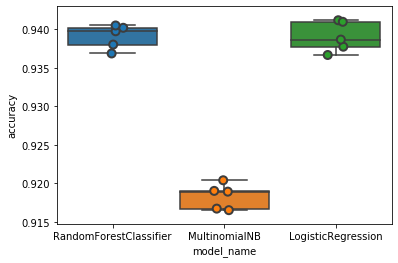

In [199]:
predictors = ['age', 'industry_code', 'occupation_code',
              'dividend_from_Stocks', 
             ]
test_models(predictors, 5)

LogisticRegression and RandomForest have the highest mean accuracy, then NB.

# Model using all features

RandomForestClassifier
  Accuracy: 0.950828 (0.001232)
MultinomialNB
  Accuracy: 0.910311 (0.001651)
LogisticRegression


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

  Accuracy: 0.943786 (0.001468)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


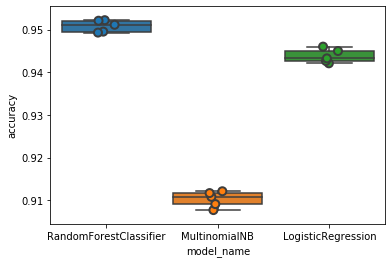

In [200]:
predictors = ['age','class_of_worker','industry_code','occupation_code','education','wage_per_hour','marital_status',
                 'race', 'sex','capital_losses','dividend_from_Stocks','num_person_Worked_employer','business_or_self_employed',
                 'weeks_worked_in_year','year']

test_models(predictors, 5)

Results are comparable but RadomForest performance is better.

Overall, Random Forest Classifier performed the best with our train and testing data set. 